In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import measurements
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
from collections import deque
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
import pickle
import time

In [ ]:
os.mkdir('./from_test_video/')

In [ ]:
cam = cv2.VideoCapture('./test_video.mp4')

ret = True
cntr = 0

while(ret):
    ret, img = cam.read()
    if ret:
        cntr += 1
        fname = str(cntr)+'.jpg'
        cv2.imwrite(os.path.join('./from_test_video/', fname), img)

In [27]:
imgs = None
for f in os.listdir('./from_test_video/'):
    img = cv2.imread(os.path.join('./from_test_video/', f))
    if img is not None:
        if imgs is None:
            imgs = img[np.newaxis]
        else:
            imgs = np.vstack([imgs, img[np.newaxis]])

In [28]:
imgs.shape

(23, 720, 1280, 3)

In [29]:
cut_imgs = imgs[:, :, 0:600, :]

In [ ]:
plt.imshow(cut_imgs[0])

In [30]:
def gen_random_samples(imgs, n_samples, saving_path, winsize=64):
    n_per_img = math.ceil(n_samples/imgs.shape[0])
    im_shape = imgs.shape
    max_y = im_shape[1] - winsize
    max_x = im_shape[2] - winsize
    cntr = 0
    print('samples per image: %f' % n_per_img)
    for img in imgs:
        ys = np.random.randint(0, high=max_y, size=n_per_img)
        xs = np.random.randint(0, high=max_x, size = n_per_img)
        for y,x in zip(ys, xs):
            win_img = img[y:y+winsize, x:x+winsize, :]
            cntr += 1
            fname = str(cntr) + '.jpg'
            cv2.imwrite(os.path.join(saving_path, fname), win_img)
    

In [ ]:
os.mkdir('./hard_negatives')

In [31]:
saving_path = './hard_negatives/'

In [32]:
gen_random_samples(cut_imgs, 2000, saving_path)

samples per image: 87.000000


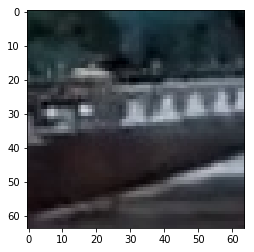

In [26]:
plt.imshow(cv2.imread('./hard_negatives/100.jpg'))

In [ ]:
output='./project_video.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

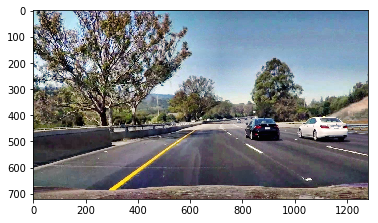

In [15]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
hist_img = None
for ch in range(3):
    cl1 = clahe.apply(imgs[0][...,ch])
    if hist_img is None:
        hist_img = cl1
    else:
        hist_img = np.dstack([hist_img, cl1])
plt.imshow(cv2.cvtColor(hist_img, cv2.COLOR_BGR2RGB))

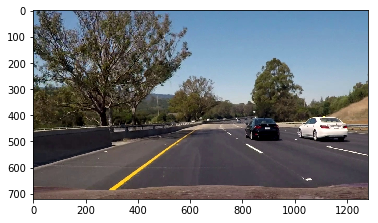

In [16]:
plt.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB))

In [22]:
normalizedImg = cv2.normalize(imgs[0], normalizedImg, 0, 255, cv2.NORM_MINMAX)

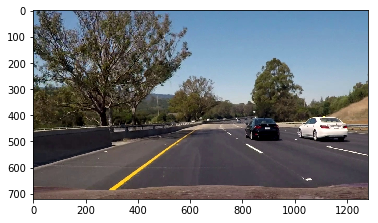

In [23]:
plt.imshow(cv2.cvtColor(normalizedImg, cv2.COLOR_BGR2RGB))

In [21]:
cv2.normalize?